In [4]:
import datetime
import os
import re
import sys
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat



In [5]:
# Initializing y-axis labels (only one time)
p = np.arange(1.75, -2.25, -0.25).tolist()
n = ['{:.2f}'.format(x) for x in p]

# Datetime transformation for CSI timestamps (only one time)
time_apply = lambda t: np.datetime64(t)
vfunc = np.vectorize(time_apply)

In [6]:
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled


# load mmWave spectrogram (array) with back ground removal method(by Isura)
def load_mmwave(path):
    image = []
    timestamps = []
    file_input = open(path, 'r')
    lines = file_input.readlines()
    for line in lines:
        if not line == '\n':
            timestamp = line[3:16]  # Extracting timestamp
            new_line = line[17:].split(',')  # Extracting power values.
            new_line = [int(i) for i in new_line]
            newline = np.array(new_line)
            p = newline.reshape(16, 128)  # Reshaping to 16 velocity bins and 128 range bins
            mean_row = np.mean(p[:, :], axis=1)  # Selecting only 0:105 range bins (0 -4.8m) and average
            image.append(mean_row)
            converted_timestamp = datetime.datetime.utcfromtimestamp(int(timestamp) / 1000.0).strftime(
                '%Y-%m-%d %H:%M:%S.%f')
            timestamps.append(np.datetime64(converted_timestamp))
    background = np.mean(image[:2], axis=0)
    # Background removal
    processed = []
    for line in image:
        line = line - background
        processed.append(line)
    return np.array(processed).T, timestamps

# load the mmWave spectrogram (array)
def load_original_mmwave(path):
    image = []
    timestamps = []
    file_input = open(path, 'r')
    lines = file_input.readlines()
    for line in lines:
        if not line == '\n':
            timestamp = line[3:16]  # Extracting timestamp
            new_line = line[17:].split(',')  # Extracting power values.
            new_line = [int(i) for i in new_line]
            newline = np.array(new_line)
            p = newline.reshape(16, 128)  # Reshaping to 16 velocity bins and 128 range bins
            mean_row = np.mean(p[:, :], axis=1)  # Selecting only 0:105 range bins (0 -4.8m) and average
            image.append(mean_row)
            converted_timestamp = datetime.datetime.utcfromtimestamp(int(timestamp) / 1000.0).strftime(
                '%Y-%m-%d %H:%M:%S.%f')
            timestamps.append(np.datetime64(converted_timestamp))
    background = np.mean(image[:2], axis=0)
    # Background removal
    processed = []
    for line in image:
        # line = line - background
        processed.append(line)
    return np.array(processed).T, timestamps

# show a slice of mmWave spectrogram (used to extract the single gesture out from the whole spectrogram)
def show_mmWave(range_start, range_end, line_start=None, line_end=None):
    plt.tight_layout()
    p = np.arange(45, -55, -1).tolist()
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    plt.setp(axs, yticks=range(16), yticklabels=n, xlabel='Frame', ylabel='Velocity (m/s)')
    axs.grid(axis='x')
    axs.imshow(mmwave[:, range_start:range_end], aspect='auto', interpolation='sinc')
    if line_start and line_end:
        plt.axvline(x=line_start, color="red")  # Starting gesture index
        plt.axvline(x=line_end, color="red")  # Ending gesture index
    plt.show()

In [7]:
# assistant function: find the all possible gestures pattern from the mmWave
def find_True_range(arr, tolerance=10) -> list:
    r = []
    start = None
    current_tolerance = 0
    for n, i in enumerate(arr):
        if i == True and start is None:
            start = n
        if not any(arr[n:n + tolerance]) and start:
            r.append((start, n))
            start = None
    return r

# assistant function: get rid of the unusual gestures based on the duration
def remove_extreme_value(arr, gesture_len_range=(5, 25)) -> list:
    # gesture filter --> remove the gesture that in different size
    ## example: r = [[5,10], [14,19], [20,45], [50,55], [60,61]]
    ##             then we have gesture which length is [5, 5, 25, 5, 1]
    ##              since 25 and 1 are likely not a good gesture, remove them form the array
    # get rid of the extreme value

    length_arr = list(map(lambda x: x[1] - x[0], arr))
    std = np.std(length_arr)
    m = np.median(length_arr)  # we use median instead of mean

    out = []
    for n, i in enumerate(length_arr):
        if (m - 3 * std) < i < (m + 3 * std) and gesture_len_range[0] <= i <= gesture_len_range[1]:
            out.append(arr[n])
    return out

# assistant function: time stamp matching for mmWave and CSI
def ts_finding(start_frame, end_frame):
    starting_ts = mmwave_timestamps[start_frame]
    ending_ts = mmwave_timestamps[end_frame]

    start_founded = False
    end_founded = False
    for thresh in range(100, 300):
        if all([start_founded, end_founded]):
            return start_index, end_index
        for i in csi_timestamps:
            if not start_founded:
                if abs(starting_ts - i) < np.timedelta64(thresh, 'ms'):
                    start_founded = True
                    start_index = np.where(csi_timestamps == i)[0][0]

            else:
                if abs(ending_ts - i) < np.timedelta64(thresh, 'ms'):
                    end_founded = True
                    end_index = np.where(csi_timestamps == i)[0][0]
                    break

    raise ValueError

In [21]:
# path configuration
# warning: in this jupyter notebook, it will only process 1 folder instead of all;

directorys = [r"G:\2020_12_09_problem_dataset"]
for directory in directorys:
    filenames = [re.match('(.+)_mm_2.txt', file).group(1) for file in os.listdir(directory) if 'mm_2.txt' in file]

    for filename in filenames:
        # txt_file = f"{directory}\\{filename}.txt"
        # mat_file = f"{directory}\\{filename}.mat"
        txt_file = f"{directory}\\{filename}_mm_2.txt"
        mat_file = f"{directory}\\{filename}.mat"

        if not (os.path.exists(txt_file) and os.path.exists(mat_file)):
            print(f"File not exist: {txt_file} / {mat_file}")
            continue

In [22]:
# ouput config
output_directory = f"{directory}\\{filename}"
if not os.path.exists(output_directory):
    os.mkdir(output_directory)


# General setting
TEST_RANGE = 0 # which means test all the file
# TEST_RANGE = 200 # if only wants to test a fraction of the mmWave
FILTER_THRESH = 15

# loading files
mmwave, mmwave_timestamps = load_mmwave(txt_file)
csi_workspace = loadmat(mat_file)
csi = csi_workspace['doppler_spectrum'][0]
csi_timestamps = csi_workspace['time_matlab_string']
csi_timestamps = vfunc(csi_timestamps)

print(filename)
print(f"CSI min:{min(csi_timestamps)}, max:{max(csi_timestamps)}\nmmWave min:{min(mmwave_timestamps)}, max:{max(mmwave_timestamps)}")
COLOR_THRESHOLD = np.percentile(mmwave, 98)


mmwave_original, mmwave_timestamps = load_original_mmwave(txt_file)

if TEST_RANGE == 0:
    TEST_RANGE = mmwave.shape[-1]




2020_12_09_legswing_p20
CSI min:2020-12-09T02:47:44.498, max:2020-12-09T02:52:50.476
mmWave min:2020-12-09T02:47:44.961000, max:2020-12-09T02:52:54.498000


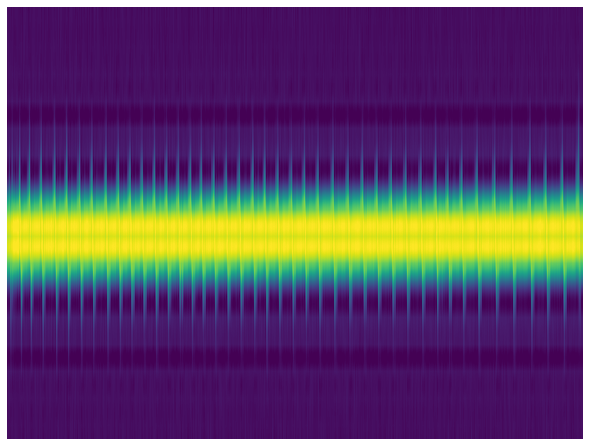

In [23]:
# show the original mmwave
_, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax1.imshow(mmwave_original[:, :TEST_RANGE], aspect='auto', interpolation='sinc')
plt.axis('off')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.savefig(f'{output_directory}\\original_mmwave.png', format='png')

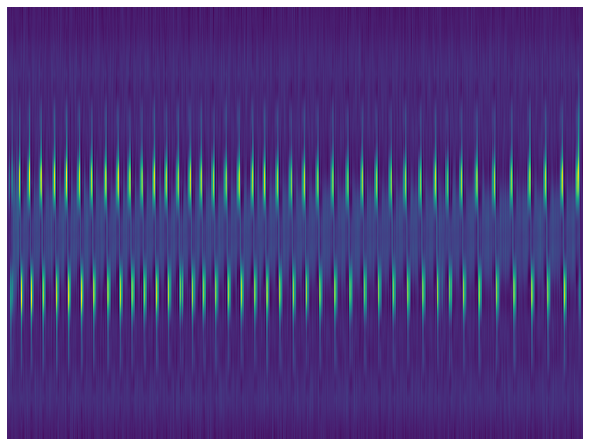

In [24]:
# Save mmwave image (background removed)
mmwave, mmwave_timestamps = load_mmwave(txt_file)
_, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax1.imshow(mmwave[:, :TEST_RANGE], aspect='auto', interpolation='sinc')
plt.axis('off')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.savefig(f'{output_directory}\\original_mmwave_bg_removed.png', format='png')

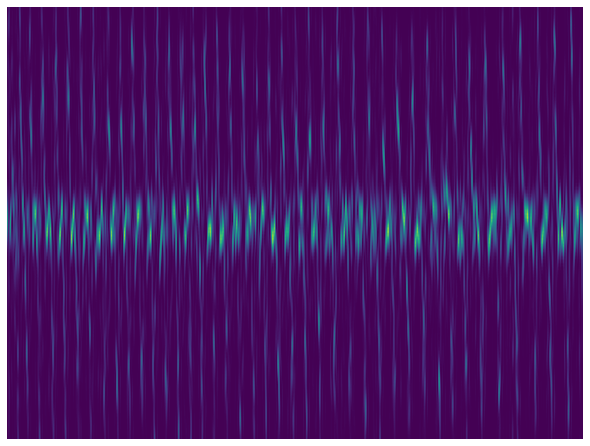

In [29]:
# Save orignal csi image
_, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax1.imshow(csi[:, 0:int(TEST_RANGE * 25)], aspect='auto', interpolation='sinc')
plt.axis('off')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.savefig(f'{output_directory}\\original_wifi.png', format='png')


<Figure size 432x288 with 0 Axes>

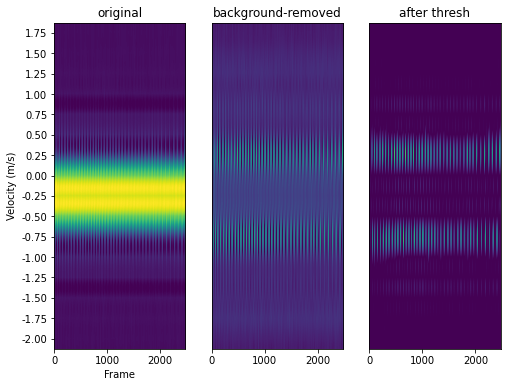

In [28]:
# compare the CSI/mmWave
plt.tight_layout()
p = np.arange(45, -55, -1).tolist()
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 6))
plt.setp(ax1, yticks=range(16), yticklabels=n, xlabel='Frame', ylabel='Velocity (m/s)')

origin_mmwave = mmwave[:, :TEST_RANGE]

# set an threshold
data = origin_mmwave > COLOR_THRESHOLD

# axs.title = "thresh images"
ax1.set_title("original")
ax2.set_title("background-removed")

ax1.imshow(mmwave_original[:, :TEST_RANGE], aspect='auto', interpolation='sinc')
ax3.set_title("after thresh")
ax2.imshow(origin_mmwave, aspect='auto', interpolation='sinc')
ax3.imshow(data, aspect='auto', interpolation='sinc')
ax2.set_yticks([])
ax3.set_yticks([])

plt.savefig(f'{output_directory}\\out2.png', format='png')
plt.show()




In [32]:
# core function: find the gesture from mmWave spectrogram

# scan col by col
# np.transpose(data)

## find per col, if there is any value > 0, then consider as a start
trans_data = [any(col) for col in np.transpose(data)]
true_range = find_True_range(trans_data)

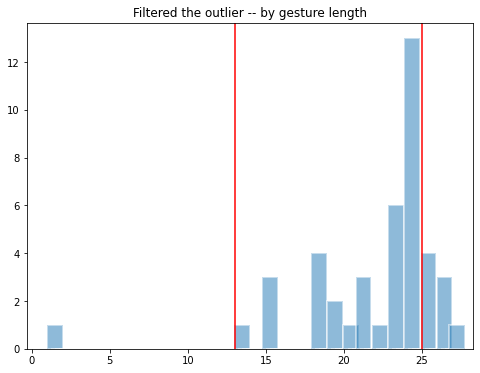

In [34]:
# show the filter result (gesture on mmWave)
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax1.set_title("Filtered the outlier -- by gesture length")
ax1.hist(list(map(lambda x: x[1] - x[0], true_range)), 100, alpha=0.5, width=1, edgecolor='white', linewidth=2)

# filter
# (length-mean)/std
try:
    true_range_filted = remove_extreme_value(true_range)
    lower_bound = min(list(map(lambda x: x[1] - x[0], true_range_filted)))
    upper_bound = max(list(map(lambda x: x[1] - x[0], true_range_filted)))
    ax1.axvline(x=lower_bound, color="red")
    ax1.axvline(x=upper_bound, color="red")
except:
    pass
plt.savefig(f'{output_directory}\\outlier filter.png', format='png')

plt.show()

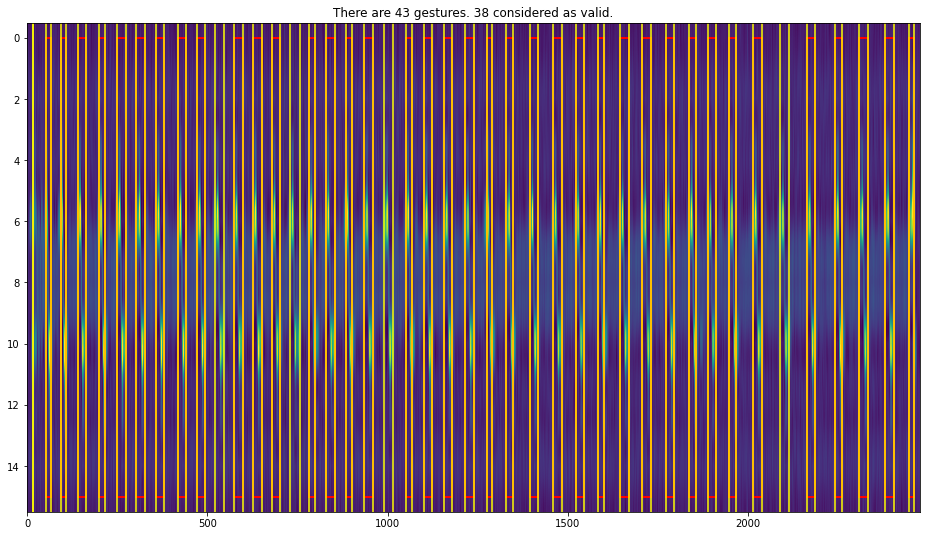

In [31]:
# show the gestures on mmWave
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
axs.set_title(f"There are {len(true_range)} gestures. {len(true_range_filted)} considered as valid.")
axs.imshow(origin_mmwave, aspect='auto', interpolation='sinc')
for mm_start, mm_end in true_range:
    plt.axvline(x=mm_start, color="yellow")  # Starting gesture index
    plt.axvline(x=mm_end, color="yellow")  # Ending gesture index

for mm_start, mm_end in true_range_filted:
    rect = plt.Rectangle((mm_start, 0), mm_end - mm_start, 15, fill=False, edgecolor='red', linewidth=2)
    axs.add_patch(rect)
plt.savefig(f'{output_directory}\\mmwave_selected.png', format='png')
plt.show()

2020_12_09_legswing_p20_1.npz
2020_12_09_legswing_p20_2.npz
2020_12_09_legswing_p20_3.npz
2020_12_09_legswing_p20_4.npz
2020_12_09_legswing_p20_5.npz
2020_12_09_legswing_p20_6.npz
2020_12_09_legswing_p20_7.npz
2020_12_09_legswing_p20_8.npz
2020_12_09_legswing_p20_9.npz
2020_12_09_legswing_p20_10.npz
2020_12_09_legswing_p20_11.npz
2020_12_09_legswing_p20_12.npz
2020_12_09_legswing_p20_13.npz
2020_12_09_legswing_p20_14.npz
2020_12_09_legswing_p20_15.npz
2020_12_09_legswing_p20_16.npz
2020_12_09_legswing_p20_17.npz
2020_12_09_legswing_p20_18.npz
2020_12_09_legswing_p20_19.npz
2020_12_09_legswing_p20_20.npz
2020_12_09_legswing_p20_21.npz
2020_12_09_legswing_p20_22.npz
2020_12_09_legswing_p20_23.npz
2020_12_09_legswing_p20_24.npz
2020_12_09_legswing_p20_25.npz
2020_12_09_legswing_p20_26.npz
2020_12_09_legswing_p20_27.npz
2020_12_09_legswing_p20_28.npz
2020_12_09_legswing_p20_29.npz
2020_12_09_legswing_p20_30.npz
2020_12_09_legswing_p20_31.npz
2020_12_09_legswing_p20_32.npz
2020_12_09_legswi

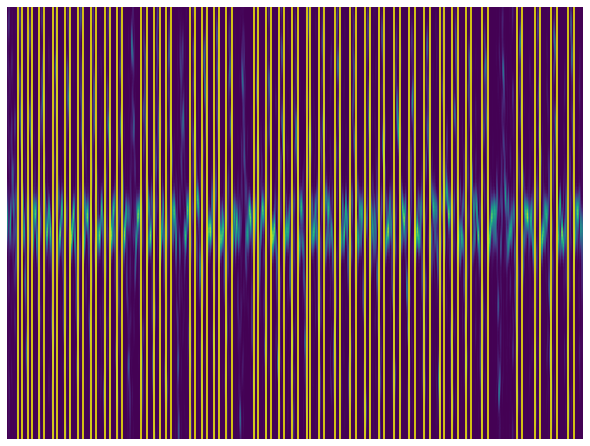

In [36]:
# match with CSI and output

# plot the CSI
_, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax1.imshow(csi[:, 0:int(TEST_RANGE * 25)], aspect='auto', interpolation='sinc')
plt.axis('off')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.savefig(f'{output_directory}\\original_wifi_plot.png', format='png')


# do the matching
file_n = 0
for mm_start, mm_end in true_range_filted:
    file_n += 1
    try:
        csi_start, csi_end = ts_finding(mm_start, mm_end)
    except:
        print(f'{mat_file}: cant match the csi file, skip..')
    else:
        plt.axvline(x=csi_start, color="yellow")  # Starting gesture index
        plt.axvline(x=csi_end, color="yellow")  # Ending gesture index

        scaled_csi = scale_minmax(csi[:, csi_start:csi_end])
        scaled_mmwave = scale_minmax(mmwave[:, mm_start:mm_end])
        save_filename = f'{filename}_{file_n}.npz'
        np.savez(f"{output_directory}\\{save_filename}", a=scaled_csi, b=scaled_mmwave)
        print(save_filename)

# show plot
plt.savefig(f'{output_directory}\\wifi_selected.png', format='png')
plt.show()